# Домашнее задание: рекомендательные системы

В этом домашнем задании будем работать с данными о пользователях и оценках, которые они поставили различным фильмам.

На основе этих данных будем рекомендовать пользователям к просмотру новые для них фильмы.

* За решение всех пунктов из домашнего задания можно получить 11 баллов максимум.
* В ведомость курса ставится балл, равный **min(ваш набранный балл, 10)**.

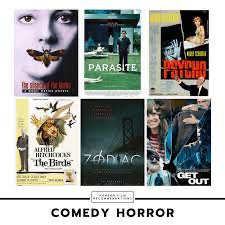

В домашней работе вы примените как базовые методы для построения рекомендаций, так и Deep Learning подходы.

Базово выполнения этой работы вам будут полезны:

* [Семинар с курса по ML в нашей магистратуре](https://github.com/Murcha1990/MLDS_ML_2022/blob/main/Занятие_13_Recsys1/MLHS_Recsys_1.ipynb)
* [Ноутбук из урока на Stepik](https://colab.research.google.com/drive/1RirfhDfR_ZAb_S6UhP-F2TBtL9eNX9VG)

(по сути это один и тот же код, но немного в разном оформлении).

Для выполнения Deep Learning-части пригодятся дополнительные материалы, ссылки на которые вы найдете в нижней части ноутбука.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import List, Dict
from tqdm import tqdm, tqdm_notebook

## 0. Загрузка и обработка данных

Загрузим данные.

In [2]:
ratings = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movies_ratings.csv')

In [3]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = item_encoder.fit_transform(ratings['movieId'])

num_users, num_movies = ratings.userId.nunique(), ratings.movieId.nunique()
num_users, num_movies

(671, 9025)

Поделим выборку на train и test так, чтобы у каждого пользователя последние 10 фильмов оказались в тесте для подсчета метрики качества рекомендаций k=10.  

In [4]:
train, test = [], []
num_test_samples = 10

for user, data in ratings.groupby('userId'):
    train += [data[:-num_test_samples]]
    test += [data[-num_test_samples:]]

train = pd.concat(train)
test = pd.concat(test)
print(train.shape, test.shape)

(93140, 5) (6710, 5)


In [5]:
train.head()

,userId,movieId,rating,timestamp,title
0,0,30,2.5,1260759144,Dangerous Minds
42,0,830,3.0,1260759179,Dumbo
84,0,856,3.0,1260759182,Sleepers
117,0,903,2.0,1260759185,Escape from New York
165,0,927,4.0,1260759205,Cinema Paradiso


Запишите данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

Назовите полученную таблицу `interactions`, действуйте по аналогии или воспользуйтесь кодом из семинара по ML.

In [6]:
interactions = (
    train
    .groupby('userId')['movieId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'movieId': 'true_train'})
    .set_index('userId')
)

interactions['true_test'] = (
    test
    .groupby('userId')['movieId'].agg(lambda x: list(x))
)

interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for _ in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
userId,,
0,"[30, 830, 856, 903, 927, 1013, 1037, 1043, 107...","[1107, 1136, 1511, 1661, 1704, 1739, 1811, 195..."
1,"[9, 16, 37, 45, 48, 49, 58, 100, 123, 129, 132...","[518, 519, 520, 521, 522, 523, 524, 525, 543, ..."
2,"[100, 266, 321, 341, 472, 521, 524, 525, 56, 2...","[5008, 5107, 5456, 5461, 5874, 6345, 6518, 656..."
3,"[1107, 1511, 1661, 1739, 2375, 9, 132, 163, 26...","[2491, 2495, 2543, 2575, 2576, 2602, 2606, 261..."
4,"[1811, 37, 129, 321, 328, 331, 341, 447, 519, ...","[5955, 5957, 6098, 6118, 6144, 6172, 6260, 627..."


Для оценки качества модели будем использовать метрику  precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним ее по всем пользователям (полученная метрика называется MAP@10).

In [7]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

# 1. Коллаборативная фильтрация (2 балла)

Составьте матрицу "оценок" пользователей - `ratings`. Нули будут обозначать отсутствие взаимодействия **(0.25 балла)**.

Действуйте по аналогии или воспользуйтесь кодом из семинара по ML.

In [8]:
ratings = pd.pivot_table(
    train,
    values='rating',
    index='userId',
    columns='movieId',
    fill_value=0
)

In [9]:
ratings.head(5)

movieId,0,1,2,3,4,5,6,7,8,9,...,8990,8992,8993,8995,8996,8998,9000,9004,9008,9010
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
ratings_m = ratings.values

Посчитайте схожести пользователей (запишите их в np.array `similarity_users`) с помощью корреляции Пирсона. Для каждой пары учитывайте только ненулевые значения **(0.5 балла)**.

Действуйте по аналогии или воспользуйтесь кодом из урока.

In [ ]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

# Подсчет схожести с помощью корреляции Пирсона
for i in tqdm(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):

        # Определяем, где оба пользователя оценили один и тот же фильм (ненулевые значения)
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)

        # Пропуск, если у пользователей нет общих оценённых фильмов
        if np.sum(mask_uv) == 0:
            continue

        # Получение общих оценок пользователей
        ratings_u = ratings_m[i, mask_uv]
        ratings_v = ratings_m[j, mask_uv]

        # Пропуск, если у пользователей нет различий в оценках
        if len(np.unique(ratings_u)) < 2 or len(np.unique(ratings_v)) < 2:
            continue

        # Вычисление корреляции Пирсона и сохранение её в матрицу схожести
        similarity_users[i, j] = np.corrcoef(ratings_u, ratings_v)[0, 1]
        similarity_users[j, i] = similarity_users[i, j]  # Симметричная матрица

100%|██████████| 670/670 [00:41<00:00, 16.02it/s] 


In [ ]:
similarity_users[0,6]

-0.4999999999999999

Сделайте user-based прогнозы по тому же правилу, что и в уроке **(1 балл)**:

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждого фильма долю пользователей (среди выделенных на первом шаге), которые взаимодействовали с этим фильмом.
3. Порекомендуем фильмы с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

Сделайте предсказания и запишите их в столбец
`prediction_user_based` таблицы `interactions`.

In [ ]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

  0%|          | 0/671 [00:00<?, ?it/s]

Посчитайте значение метрики MAP@10 для user-based подхода **(0.25 балла)**.

In [ ]:
print(calc_precision('prediction_user_based'))

0.005365126676602086


## 2. SVD-разложение (2 балла)

Для выполнения заданий при необходимости заглядывайте в ноутбук из семинара по ML.

Сделайте сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы - `U`,`sigma`,`V` **(0.5 балла)**.

In [ ]:
from scipy.linalg import svd

In [ ]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(671, 8044) (671, 671) (671,) (8044, 8044)


In [ ]:
Sigma = np.zeros((671, 8044))
Sigma[:671, :671] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

2.3503517064433228e-23


Значения у матрицы с сингулярными числами отсортированы по убыванию.

Оставьте только первые 150 компонент, чтобы получить скрытые представления размерности 150 **(0.5 балла)**.

Для этого необходимо оставить 150 столбцов в матрице U, оставить из sigma только первые 150 значений (и сделать из них диагональную матрицу) и 150 столбцов в матрице V. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [ ]:
K = 100

sigma[K:] = 0
Sigma = np.zeros((671, 8044))
Sigma[:671, :671] = np.diag(sigma)

Посчитайте качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравните его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже **(0.25 балла)**.

In [ ]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

356826.8789061344
1255671.6721978304


Теперь сделайте предсказания по матрице (не забывайте про то, что уже было просмотрено пользователем) **(0.5 балла)**.

Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [ ]:
!pip install ipywidgets
!pip install --upgrade jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
 

In [ ]:
top_k = 10

new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for userId in tqdm(interactions.index):
    prediction = (
        new_ratings
        .loc[userId]
        .sort_values(ascending=False)
        .index.values
    )

    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[userId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

100%|██████████| 671/671 [00:00<00:00, 864.86it/s]


Посчитайте значение метрики MAP@10 для SVD-подхода **(0.25 балла)**.

In [ ]:
print(calc_precision('prediction_svd'))

0.022056631892697468


# 3. Градиентный Бустинг / Библиотека CatBoost (1.5 балла)

В задаче рекомендаций так же можно использовать метод градиентного бустинга. Мы будем использовать библиотеку `CatBoost`. Для предсказаний мы будем использовать векторы после SVD разложения, которые будут показывать информацию о пользователе или фильме. На выход у нас будет оценка пользователя фильма.

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error

Сделайте снова SVD разложение и возьмите матрицу `U`, строки которой репрезентуют юзеров, и матрицу `V`, столбцы которой репрезентуют фильмы. Обрежьте эти матрицы так, чтобы и юзеры, и фильмы у нас описывались векторами размерности `50` **(0.25 балла)**.

In [ ]:
U, sigma, V = svd(ratings)

k = 50
U_reduced = U[:, :k]
V_reduced = V[:k, :]

Сконкатенируйте векторы пользователей и векторы фильмов и сбалансируйте выборку, чтобы семплов с нулевым рейтингом не было намного больше, чем семплов с не нулевым **(0.5 балла)**.

In [ ]:
X = []
y = []

for user_id in range(U_reduced.shape[0]):
    for movie_id in range(V_reduced.shape[1]):
        user_vector = U_reduced[user_id, :]
        movie_vector = V_reduced[:, movie_id]
        concatenated = np.concatenate([user_vector, movie_vector])
        X.append(concatenated)

        rating = ratings.iloc[user_id, movie_id]
        y.append(rating)

X = np.array(X)
y = np.array(y)

In [ ]:
is_zero = (y == 0).astype(int)

X_zero = X[is_zero == 1]
X_non_zero = X[is_zero == 0]
y_zero = y[is_zero == 1]
y_non_zero = y[is_zero == 0]

# Понижаем выборку, чтобы количество 0 было всего в 1.3 раза больше)
ratio = 1.3

max_zero_samples = int(len(X_non_zero) * ratio)

if len(X_zero) > max_zero_samples:
    indices = np.random.choice(len(X_zero), max_zero_samples, replace=False)
    X_zero_resampled = X_zero[indices]
    y_zero_resampled = y_zero[indices]
else:
    X_zero_resampled = X_zero
    y_zero_resampled = y_zero

X_resampled = np.vstack((X_zero_resampled, X_non_zero))
y_resampled = np.hstack((y_zero_resampled, y_non_zero))

# Перемешиваем выборки
indices = np.random.permutation(len(X_resampled))
X_resampled = X_resampled[indices]
y_resampled = y_resampled[indices]

Обучите модель градиентного бустинга **(0.25 балла)**.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, verbose=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

0:	learn: 1.7929219	total: 480ms	remaining: 7m 59s
100:	learn: 0.9442556	total: 33.3s	remaining: 4m 56s
200:	learn: 0.8418431	total: 1m 4s	remaining: 4m 17s
300:	learn: 0.7743875	total: 1m 36s	remaining: 3m 43s
400:	learn: 0.7212140	total: 2m 7s	remaining: 3m 11s
500:	learn: 0.6740039	total: 2m 39s	remaining: 2m 38s
600:	learn: 0.6320249	total: 3m 10s	remaining: 2m 6s
700:	learn: 0.5961402	total: 3m 43s	remaining: 1m 35s
800:	learn: 0.5622500	total: 4m 14s	remaining: 1m 3s
900:	learn: 0.5296472	total: 4m 46s	remaining: 31.5s
999:	learn: 0.5017671	total: 5m 17s	remaining: 0us
RMSE: 0.842599318944668


Предскажите для каждого пользователя подходящие ему фильмы **(0.25 балла)**.

In [ ]:
predicted_movies_catboost = []

# Прогнозируeм рейтинги фильмов, которые пользователь не оценил в наборе train
for user_id, row in interactions.iterrows():
    user_vector = U_reduced[user_id, :]
    unseen_movies = [i for i in range(V_reduced.shape[1]) if i not in row['true_train']]
    user_movie_vectors = np.array([np.concatenate([user_vector, V_reduced[:, movie_id]]) for movie_id in unseen_movies])

    predicted_ratings = model.predict(user_movie_vectors)
    top_movie_indices = np.argsort(predicted_ratings)[-10:]
    top_movies = [unseen_movies[i] for i in top_movie_indices]

    predicted_movies_catboost.append(top_movies)

interactions['predicted_movies_catboost'] = predicted_movies_catboost

Посчитайте значение метрики MAP@10 для подхода с градиентным бустингом **(0.25 балла)**.

In [ ]:
print(calc_precision('predicted_movies_catboost'))

0.006110283159463487


# 4. Автокодировщики (2.5 балла)

Здесь вам придется немного разобраться самостоятельно.
В [этом ноутбуке](https://colab.research.google.com/drive/1smDjB-N6ChUHve1S9bLXoeZefFp4m3iZ?usp=sharing) есть пример обучения автокодировщика для построения рекомендаций.

В этом задании обучите автокодировщик по образу и подобию того, что сделано в ноутбуке.

Удалось ли с помощью данного DL-подхода превзойти качество рекомендаций, полученных ML-методами?

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import clear_output, display

In [ ]:
SEED = 42
torch.manual_seed(SEED)

LR = 1e-3
WEIGHT_DECAY = 0.01
GAMMA = 0.9995
NUM_EPOCHS = 100
BATCH_SIZE = 3000

In [ ]:
X = ratings.values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
class UserOrientedDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        self.X = X.astype(np.float32)
        self.len = len(X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index]

class Autoencoder(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 500),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(500, in_features),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
train_dl = DataLoader(UserOrientedDataset(X_train), batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(UserOrientedDataset(X_test), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder(in_features=X.shape[1]).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [ ]:
def rmse_for_sparse(x_pred, x_true):
    mask = (x_true > 0)
    sq_diff = (x_pred * mask - x_true) ** 2
    mse = sq_diff.sum() / mask.sum()
    return mse ** 0.5

In [ ]:
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Test RMSE": [],
}

for epoch in tqdm(range(NUM_EPOCHS)):
    metrics_dict["Epoch"].append(epoch)

    for stage in ['train', 'test']:
        with torch.set_grad_enabled(stage == 'train'):
            if stage == 'train':
                model.train()
            else:
                model.eval()

            loss_at_stage = 0
            for batch in (train_dl if stage == 'train' else test_dl):
                batch = batch.to(DEVICE)
                x_pred = model(batch)
                loss = rmse_for_sparse(x_pred, batch)

                if stage == "train":
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                loss_at_stage += loss.item() * len(batch)

            rmse_at_stage = (loss_at_stage / len(train_dl.dataset if stage == 'train' else test_dl.dataset)) ** 0.5
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)

    scheduler.step()

    if (epoch == NUM_EPOCHS - 1) or epoch % 10 == 9:
        clear_output(wait=True)
        display(pd.DataFrame(metrics_dict))

,Epoch,Train RMSE,Test RMSE
0,0,1.916121,1.759334
1,1,1.809514,1.702645
2,2,1.726831,1.692231
3,3,1.612488,1.677263
4,4,1.528850,1.674592
...,...,...,...
95,95,0.783101,1.314209
96,96,0.782513,1.325061
97,97,0.781716,1.316057
98,98,0.780927,1.323025


100%|██████████| 100/100 [00:02<00:00, 36.33it/s]


In [ ]:
model.eval()
with torch.no_grad():
    X_pred = model(torch.Tensor(X).to(DEVICE)).cpu().numpy()

predicted_movies = np.argsort(-X, axis=1)[:, :10]
predicted_movies_df = pd.DataFrame(predicted_movies, columns=[f'predicted_movie_{i}' for i in range(10)])
predicted_movies_df['predicted_movies_ae'] = predicted_movies_df.apply(list, axis=1)
predicted_movies_df = predicted_movies_df[['predicted_movies_ae']]

In [ ]:
interactions = pd.concat([interactions, predicted_movies_df], axis=1)
print(calc_precision('predicted_movies_ae'))

0.0067064083457526085


C помощью автокодировщика превзойти качество рекомендаций, полученных ML-методами (CatBoost, например), на 0.0006.

# 5. Другие методы DL* (3 балла)

*Этот пункт со звездочкой, потому что потребует от вас действительно вникнуть в DL-подходы для построения рекомендательных систем.*

Реализуйте более сложные DL-подходы для построения рекомендаций: DSSM и/или NCF. Также вы можете попробовать что-то другое.

Вы можете пользоваться кодом из этих ноутбуков:
* [ноутбук с NCF-моделью](https://colab.research.google.com/drive/1rPL4Tkw_QaXmxDIPOflr1mRfW1VyoHsm?usp=sharing)

* [ноутбук с DSSМ-моделью](https://colab.research.google.com/drive/1KRJv2tlFjIbmO6sKcJo-M447O108JYd_?usp=sharing)

Вы не ограничены в способе реализации и применения подходов, а также в признаках, на которых обучаете модели.

**За каждый корректно реализованный подход - 1.5 балла (но не более 3 баллов за задание).**

**NCF-модель**

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import clear_output, display

In [15]:
SEED = 42
torch.manual_seed(SEED)

LR = 1e-3
WEIGHT_DECAY = 0.01
GAMMA = 0.9995
NUM_EPOCHS = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [16]:
class NCFDataset(Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(NCFDataset, self).__init__()

        """ Note that the labels are only useful when training, we thus
            add them in the ng_sample() function.
        """

        self.features_ps = list(features)
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.labels = [0 for _ in range(len(features))]
        self.features_fill = []
        self.labels_fill = []

    def ng_sample(self):

        assert self.is_training, "no need to sampling when testing"

        self.features_ng = []
        for x in self.features_ps:
            u = x[0]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_ng.append([u, j])

        # тру метрки классов
        labels_ps = [1 for _ in range(len(self.features_ps))]
        labels_ng = [0 for _ in range(len(self.features_ng))]

        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng

    def __len__(self):
        return (self.num_ng + 1) * len(self.labels)

    def __getitem__(self, idx):

        features = self.features_fill if self.is_training else self.features_ps
        labels = self.labels_fill if self.is_training else self.labels

        user = features[idx][0]
        item = features[idx][1]
        label = labels[idx]
        return user, item, label

In [17]:
feature_columns = ["userId", "movieId"]
train_data = train[feature_columns].values
test_data = test[feature_columns].values

In [18]:
user_dim = num_users
movie_dim = num_movies
embedding_dim = 50

In [19]:
import scipy.sparse as sp

# load ratings as a dok matrix
train_mat = sp.dok_matrix((user_dim, movie_dim), dtype=np.float32)
for x in train_data:
    train_mat[x[0], x[1]] = 1.0

In [20]:
train_ds = NCFDataset(train_data, movie_dim, train_mat, num_ng=1, is_training=True)
test_ds = NCFDataset(test_data, movie_dim, train_mat, is_training=False)
train_ds.ng_sample()

In [21]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=100, shuffle=False, num_workers=0)

In [20]:
import torch.optim as optim

class NCF(nn.Module):
    def __init__(
        self,
        user_num,
        item_num,
        factor_num,
        num_layers,
        dropout,
        model,
        GMF_model=None,
        MLP_model=None,
    ):
        super(NCF, self).__init__()

        """
        user_num: number of users;
        item_num: number of items;
        factor_num: number of predictive factors;
        num_layers: the number of layers in MLP model;
        dropout: dropout rate between fully connected layers;
        model: 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre';
        GMF_model: pre-trained GMF weights;
        MLP_model: pre-trained MLP weights.
        """

        self.dropout = dropout
        self.model = model
        self.GMF_model = GMF_model
        self.MLP_model = MLP_model

        self.embed_user_GMF = nn.Embedding(user_num, factor_num)
        self.embed_item_GMF = nn.Embedding(item_num, factor_num)

        self.embed_user_MLP = nn.Embedding(
            user_num, factor_num * (2 ** (num_layers - 1))
        )
        self.embed_item_MLP = nn.Embedding(
            item_num, factor_num * (2 ** (num_layers - 1))
        )

        MLP_modules = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            MLP_modules.append(nn.Dropout(p=self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size // 2))
            MLP_modules.append(nn.ReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)

        if self.model in ["MLP", "GMF"]:
            predict_size = factor_num
        else:
            predict_size = factor_num * 2
        self.predict_layer = nn.Linear(predict_size, 1)

        self._init_weight_()

    def _init_weight_(self):

        """We leave the weights initialization here."""

        if not self.model == "NeuMF-pre":
            nn.init.normal_(self.embed_user_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_user_MLP.weight, std=0.01)
            nn.init.normal_(self.embed_item_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_item_MLP.weight, std=0.01)

            for m in self.MLP_layers:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)

            nn.init.kaiming_uniform_(
                self.predict_layer.weight, a=1, nonlinearity="sigmoid"
            )

            for m in self.modules():
                if isinstance(m, nn.Linear) and m.bias is not None:
                    m.bias.data.zero_()
        else:
            # embedding layers
            self.embed_user_GMF.weight.data.copy_(self.GMF_model.embed_user_GMF.weight)
            self.embed_item_GMF.weight.data.copy_(self.GMF_model.embed_item_GMF.weight)
            self.embed_user_MLP.weight.data.copy_(self.MLP_model.embed_user_MLP.weight)
            self.embed_item_MLP.weight.data.copy_(self.MLP_model.embed_item_MLP.weight)

            # mlp layers
            for (m1, m2) in zip(self.MLP_layers, self.MLP_model.MLP_layers):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            # predict layers
            predict_weight = torch.cat(
                [
                    self.GMF_model.predict_layer.weight,
                    self.MLP_model.predict_layer.weight,
                ],
                dim=1,
            )

            precit_bias = (
                self.GMF_model.predict_layer.bias + self.MLP_model.predict_layer.bias
            )

            self.predict_layer.weight.data.copy_(0.5 * predict_weight)
            self.predict_layer.bias.data.copy_(0.5 * precit_bias)

    def forward(self, user, item):

        if not self.model == "MLP":
            embed_user_GMF = self.embed_user_GMF(user)
            embed_item_GMF = self.embed_item_GMF(item)
            output_GMF = embed_user_GMF * embed_item_GMF

        if not self.model == "GMF":
            embed_user_MLP = self.embed_user_MLP(user)
            embed_item_MLP = self.embed_item_MLP(item)
            interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
            output_MLP = self.MLP_layers(interaction)

        if self.model == "GMF":
            concat = output_GMF
        elif self.model == "MLP":
            concat = output_MLP
        else:
            concat = torch.cat((output_GMF, output_MLP), -1)

        prediction = self.predict_layer(concat)
        return prediction.view(-1)

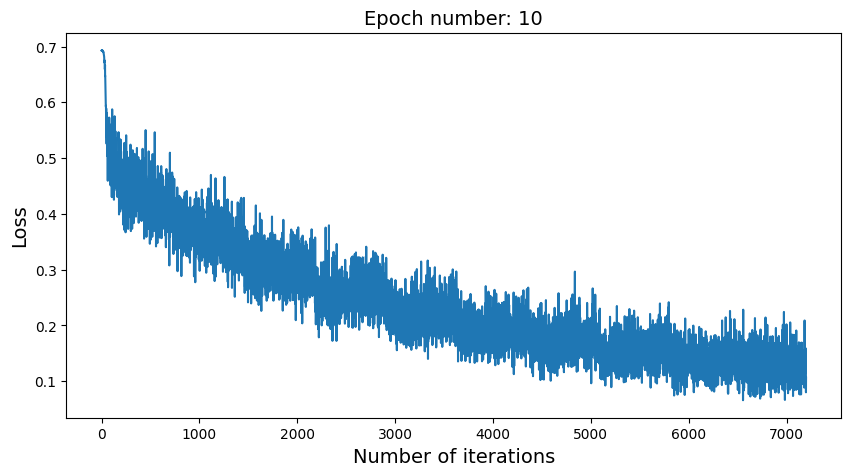

In [36]:
model = NCF(
    user_dim, movie_dim, factor_num=32, num_layers=3, dropout=0.0, model="NeuMF-end"
)
model.to(DEVICE)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_val = []

for epoch in range(10):

    model.train()
    train_dl.dataset.ng_sample()

    for user, item, label in train_dl:
        user = user.to(DEVICE)
        item = item.to(DEVICE)
        label = label.float().to(DEVICE)

        model.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

        # Plot learning curve
        loss_val.append(loss.cpu().detach().numpy())

        if len(loss_val) % 100 != 0:
            continue

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(loss_val)
        plt.xlabel("Number of iterations", size=14)
        plt.ylabel("Loss", size=14)
        plt.title("Epoch number: " + str(epoch + 1), size=14)
        plt.show()

**Метрики качества предсказания событий:**

$$Hitrate@k = |R_u (k) \cap L_u|$$

$$Precision@k = \frac{|R_u (k) \cap L_u|}{|R_u (k)|}$$

$$Recall@k = \frac{|R_u (k) \cap L_u|}{|L_u|}$$

где $R_u$ (k) - список k лучших рекомендаций алгоритма; $L_u$ - список фильмов, которые пользователь реально посмотрел.

**Метрики качества ранжирования:**

$$ DCG@k =  \sum_{p=1}^{k} g(r_{ui_{p}}) d(p) $$

где $p$ - позиция фильма в списке рекомендаций; $g(r) = 2^r - 1$; $d(p) = \frac{1}{\log(p+1)}$.

$$ nDCG@k =  \frac{DCG@k}{max DCG@k}$$

In [27]:
def hit(gt_item, pred_items):
    if gt_item in pred_items:
        return 1
    return 0

In [28]:
def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index + 2))
    return 0

In [29]:
def precision(gt_item, pred_items):
    if gt_item in pred_items:
        return 1 / len(pred_items)
    return 0

In [30]:
def metrics(model, test_loader, top_k):
    HR, NDCG, Precision = [], [], []

    for user, item, label in test_loader:

        user = user.to(DEVICE)
        item = item.to(DEVICE)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))
        Precision.append(precision(gt_item, recommends))


    return np.mean(HR), np.mean(NDCG), np.mean(Precision) # Используем среднее по юзерам чтобы из precision@10 получить map@10

In [44]:
model.eval()
HR, NDCG, MAP = metrics(model, test_dl, top_k=10)
print(f'Hitrate@10: {HR};\nnDCG@10: {NDCG};\nMap@10: {MAP}')

Hitrate@10: 0.19117647058823528;
nDCG@10: 0.09686903615129436;
Map@10: 0.019117647058823534


Результат схож с SVD-разложением(0.022).

**DeepFM**

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import clear_output, display

In [11]:
SEED = 42
torch.manual_seed(SEED)

LR = 1e-3
WEIGHT_DECAY = 0.01
GAMMA = 0.9995
NUM_EPOCHS = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [17]:
class DeepFMDataset(Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(DeepFMDataset, self).__init__()

        """ Note that the labels are only useful when training, we thus
            add them in the ng_sample() function.
        """

        self.features_ps = list(features)
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.labels = [0 for _ in range(len(features))]
        self.features_fill = []
        self.labels_fill = []

    def ng_sample(self):

        assert self.is_training, "no need to sampling when testing"

        self.features_ng = []
        for x in self.features_ps:
            u = x[0]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_ng.append([u, j])

        # тру метрки классов
        labels_ps = [1 for _ in range(len(self.features_ps))]
        labels_ng = [0 for _ in range(len(self.features_ng))]

        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng

    def __len__(self):
        return (self.num_ng + 1) * len(self.labels)

    def __getitem__(self, idx):

        features = self.features_fill if self.is_training else self.features_ps
        labels = self.labels_fill if self.is_training else self.labels

        user = features[idx][0]
        item = features[idx][1]
        label = labels[idx]
        return user, item, label

In [18]:
feature_columns = ["userId", "movieId"]
train_data = train[feature_columns].values
test_data = test[feature_columns].values

In [19]:
user_dim = num_users
movie_dim = num_movies
embedding_dim = 50

In [20]:
import scipy.sparse as sp

# load ratings as a dok matrix
train_mat = sp.dok_matrix((user_dim, movie_dim), dtype=np.float32)
for x in train_data:
    train_mat[x[0], x[1]] = 1.0

In [21]:
train_ds = DeepFMDataset(train_data, movie_dim, train_mat, num_ng=1, is_training=True)
test_ds = DeepFMDataset(test_data, movie_dim, train_mat, is_training=False)
train_ds.ng_sample()

In [22]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=100, shuffle=False, num_workers=0)

In [32]:
import torch.optim as optim

class DeepFM(nn.Module):
    def __init__(self, user_dim, movie_dim, embedding_dim):
        super(DeepFM, self).__init__()

        self.user_embedding = nn.Embedding(user_dim, embedding_dim)
        self.movie_embedding = nn.Embedding(movie_dim, embedding_dim)

        self.fm_first_order_user = nn.Embedding(user_dim, 1)
        self.fm_first_order_movie = nn.Embedding(movie_dim, 1)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, movie):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)

        fm_first_order_user = self.fm_first_order_user(user).squeeze(1)
        fm_first_order_movie = self.fm_first_order_movie(movie).squeeze(1)

        fm_first_order = fm_first_order_user + fm_first_order_movie

        interaction = torch.cat([user_emb, movie_emb], dim=-1)
        mlp_output = self.mlp(interaction).squeeze(1)

        output = fm_first_order + mlp_output

        return output

In [35]:
model = DeepFM(user_dim, movie_dim, embedding_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

for epoch in range(10):
    model.train()

    for user, movie, label in train_dl:
        user = user.to(DEVICE)
        movie = movie.to(DEVICE)

        label = torch.ones(len(user)).float().to(DEVICE)

        model.zero_grad()
        prediction = model(user, movie)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}: Loss = {loss.item()}")

Epoch 1: Loss = 6.022751040291041e-05
Epoch 2: Loss = 1.4560666386387311e-05
Epoch 3: Loss = 7.478341558453394e-06
Epoch 4: Loss = 3.4149195471400162e-06
Epoch 5: Loss = 1.5358256177933072e-06
Epoch 6: Loss = 1.0786917528093909e-06
Epoch 7: Loss = 6.618795964641322e-07
Epoch 8: Loss = 6.679191528746742e-07
Epoch 9: Loss = 2.5336115072605025e-07
Epoch 10: Loss = 2.533454903641541e-07


In [36]:
model.eval()
HR, NDCG, MAP = metrics(model, test_dl, top_k=10)
print(f'Hitrate@10: {HR};\nnDCG@10: {NDCG};\nMap@10: {MAP}')

Hitrate@10: 0.1323529411764706;
nDCG@10: 0.04978691413358118;
Map@10: 0.013235294117647059


Как видим, качество по MAP у DeepFM уступает NCF-методу или SVD-разложению, но лучше чем автокодировщик или градиентный бустинг (CatBoost).